# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Lane detection pipeline

In [3]:
def process_image(image):
    # This function detects lane markings and annotates input image.
    
    ## Convert image to HSL color spaces
    output = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Filter for bright values in L component
    white = cv2.threshold(output[:,:,1],200,255,cv2.THRESH_BINARY)[1]
    # Extra yellow filter - Filter for fairly saturated and fairly bright values
    yellow = cv2.bitwise_and(cv2.threshold(output[:,:,1],70,255,cv2.THRESH_BINARY)[1]
              ,cv2.threshold(output[:,:,2],100,255,cv2.THRESH_BINARY)[1])
    # Combine the two filters
    output = cv2.bitwise_or(white, yellow)

    
    ## Perform morphological closing on the image
    # Define kernel for the morpholocical operations
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    # Dilate the image
    output = cv2.dilate(output, element, iterations=1)
    # Erode the image
    output = cv2.erode(output, element, iterations=1)
    
    ##
    # Define top of the ROI at 60% of image height
    top_roi = int(0.6*image.shape[0])
    # Define vertices of ROI trapezoid
    vertices = np.array([[0,image.shape[0]],[int(0.45*image.shape[1]), top_roi], 
                         [int(0.55*image.shape[1]), top_roi], [image.shape[1],image.shape[0]]])
    # Mask the ROI
    output = region_of_interest(output, [vertices])
    
    ## Separate left and right part of the images to process the two lanes separately
    # Vertices of mask for left side of the image
    left_vertices = np.array([[0,0],[0, image.shape[0]], 
                         [image.shape[1]//2, image.shape[0]], [image.shape[1]//2,0]])
    # Mask the right side
    left_points = region_of_interest(output, [left_vertices])

    # Vertices of mask for right side of the image
    right_vertices = np.array([[image.shape[1]//2, image.shape[0]], [image.shape[1]//2,0], 
                         [image.shape[1], 0], [image.shape[1],image.shape[0]]])
    right_points = region_of_interest(output, [right_vertices])

    
    ## Extract the line equation for both sides using linear regression model
    # Import lineamr model from scipy library
    from sklearn import linear_model
    # Use RANSAC regression to supress the outliers
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    # Keep only points where lane has been detected and get their x, y indices
    left_points = np.argwhere(left_points>0)
    # Split the array to x, y vectors and reshape them for use in linear model
    X = left_points[:,0].reshape(-1,1)
    y = left_points[:,1]
    # Fit the linear model
    model_ransac.fit(X, y)
    # Define x values for which we want to know the y values to plot the line
    line_X = np.array([top_roi, image.shape[0]])
    # Let the model predict the values for our x values
    leftline = model_ransac.predict(line_X[:, np.newaxis])
    # Round the prediction
    leftline = leftline.astype(int)
    # Reshape the values, so they can be argument to draw_lines() function
    leftline = np.column_stack((leftline, line_X)).flatten()
    
    ## Repeat the same thing for right line
    right_points = np.argwhere(right_points>0)
    X = right_points[:,0].reshape(-1,1)
    y = right_points[:,1]
    model_ransac.fit(X, y)
    line_X = np.array([top_roi, image.shape[0]])
    rightline = model_ransac.predict(line_X[:, np.newaxis])
    rightline = rightline.astype(int)
    rightline = np.column_stack((rightline, line_X)).flatten()
    
    ## Initialize result as empty image
    result = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    ## Store the segmented roadmarks in the green channel of result image
    result[:,:,1] = output
    ## Draw our extracted left and right lines onto red channel of result image
    draw_lines(result, [[leftline]], thickness=image.shape[1]//200)
    draw_lines(result, [[rightline]], thickness=image.shape[1]//200)
    
    # Draw the result semi-transparently on the original image
    result = weighted_img(result, image, α=.8, β=1., λ=0.)
    return result

## Test on Images


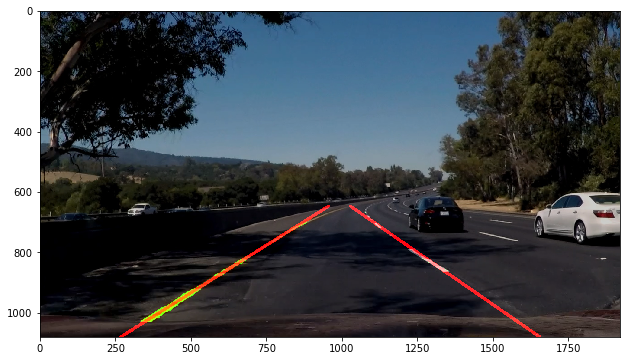

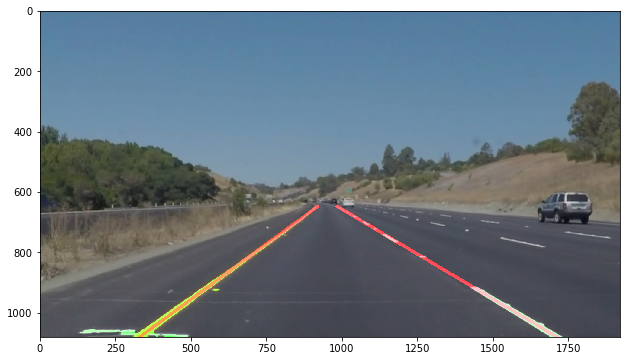

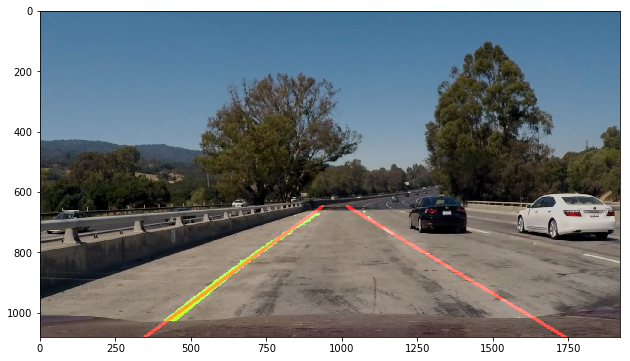

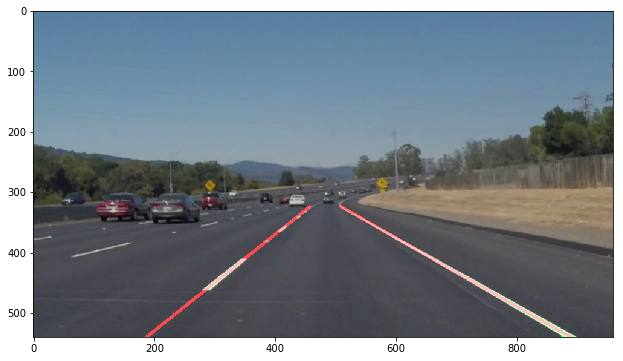

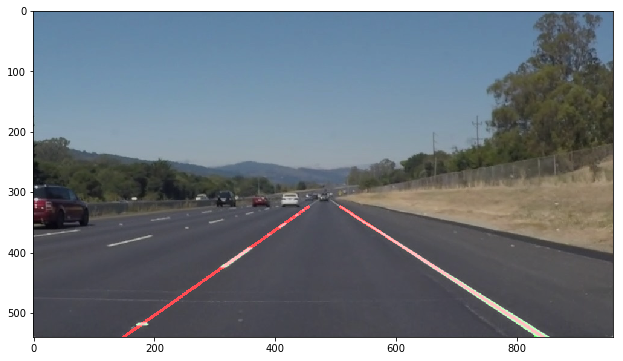

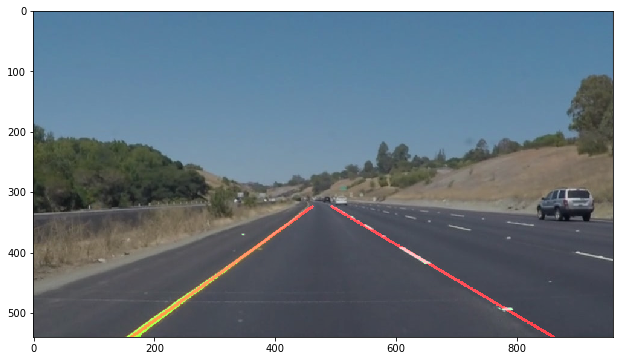

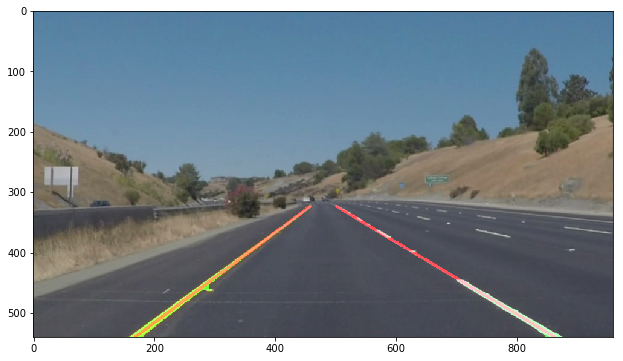

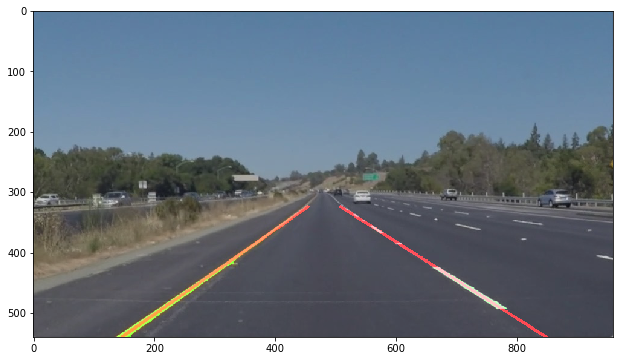

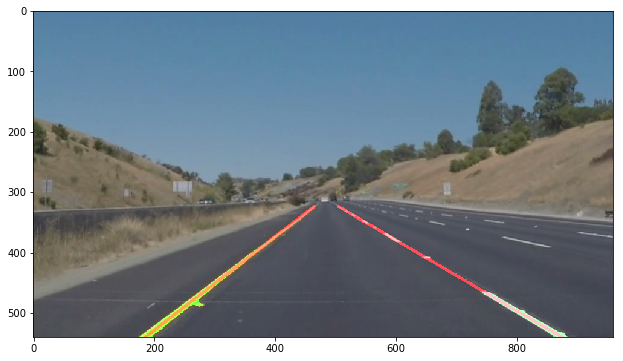

In [4]:
import os
os.listdir("test_images/")
plt.rcParams["figure.figsize"] = (20, 6)
for file in os.listdir("test_images/"):
    image = mpimg.imread('test_images/' + file)
    result = process_image(image)
    plt.imshow(result)
    plt.show()

## Test on Videos

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 26.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 9.15 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:25<00:00, 26.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 26.2 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:19<00:00, 12.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 21.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))